In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


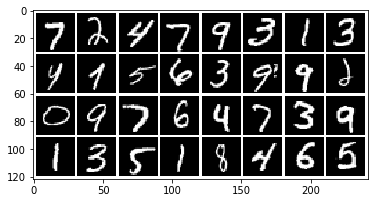

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [8]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise


def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags


def test_generator(model, device, testloader, alpha, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        ouput = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [6]:
### LOAD MODEL ####

gen = models.FCNet(imsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/FCnet_MNIST/FCNet2048MNIST_6.sd", map_location={'cuda:1': device.__str__()}));
gen.eval();

Version 0.4


In [50]:
# Calculate test predictions #

alpha = 50.0

test_original, test_predicted = test_generator(gen, device, dataloader['test'], alpha)
print(test_predicted.shape)

(8000, 1, 28, 28)


In [51]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open("/home/shared/phase-retrieval/test/FCnet_MNIST/original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(test_predicted, open("/home/shared/phase-retrieval/test/FCnet_MNIST/predicted_1024_alpha{}.p".format(alpha), "wb"))

In [52]:
### LOAD RESULTS ###
import pickle

#alpha = 0.01

test_original = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_MNIST/original_1024_alpha{}.p".format(alpha), "rb"))
test_predicted = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_MNIST/predicted_1024_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


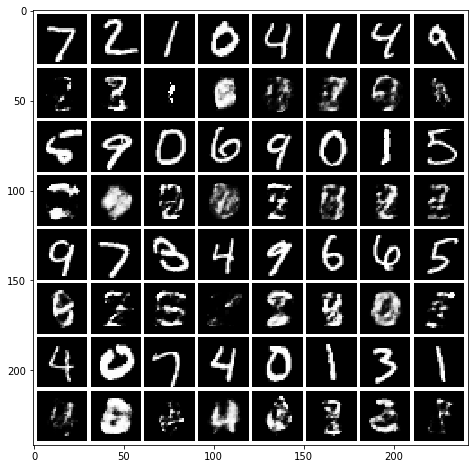

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


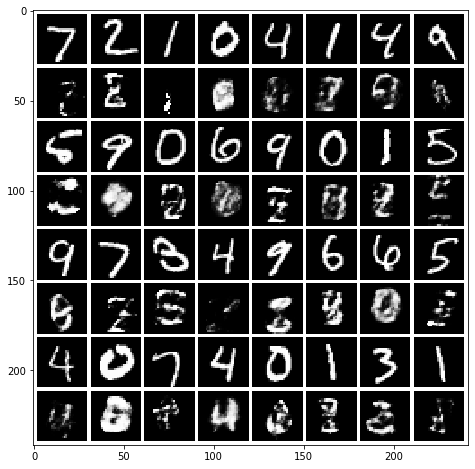

In [53]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/mnist/FCNet2048MNIST_1024_alpha{}.png".format(alpha))

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/mnist/FCNet2048MNIST_1024_alpha{}_reg.png".format(alpha))

In [54]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.08346970718503144, std: 0.027977478681765255
  MAE: 0.12082548641956237, std: 0.03590484486117085
  SSIM: 0.3520221326866885, std: 0.15908502582932638
  Sharpness: 0.15975951548202114, std: 0.036198262964337355
  PhCo-MSE: 0.08725392988253589, std: 0.035932149687274734
  PhCo-MAE: 0.1250223371298489, std: 0.04430482683958572
  PhCo-SSIM: 0.38054399157078195, std: 0.1457775694278542
  CroCo-MSE: 0.06729684926813206, std: 0.02126301843859456
  CroCo-MAE: 0.10359236743533984, std: 0.029842617207634318
  CroCo-SSIM: 0.4548863712844366, std: 0.12221956925535199

Magnitude error:
  MSE Magnitude: 21.78912084418495, std: 7.822507237934645

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.08347 | 0.1208 | 0.3520 | 0.1598 | 0.08725 | 0.1250 | 0.3805 | 0.06730 | 0.1036 | 0.4549 | 21.79 |


## Evaluation for different FC  (1024 samples)

| alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.01 | 0.02444 | 0.04858 | 0.7938 | 0.09191 | 0.02118 | 0.04439 | 0.8162 | 0.01837 | 0.04107 | 0.8345 | 4.388 |
| 0.03 | 0.02444 | 0.04858 | 0.7938 | 0.09193 | 0.02120 | 0.04441 | 0.8161 | 0.01837 | 0.04107 | 0.8345 | 4.388 |
| 0.1 | 0.02444 | 0.04859 | 0.7938 | 0.09192 | 0.02116 | 0.04438 | 0.8163 | 0.01837 | 0.04109 | 0.8344 | 4.390 |
| 0.3 | 0.02446 | 0.04866 | 0.7935 | 0.09189 | 0.02112 | 0.04436 | 0.8166 | 0.01837 | 0.04112 | 0.8343 | 4.403 |
| 1.0 | 0.02451 | 0.04920 | 0.7915 | 0.09163 | 0.02107 | 0.04475 | 0.8155 | 0.01836 | 0.04155 | 0.8333 | 4.480 |
| 3.0 | 0.02568 | 0.05327 | 0.7730 | 0.09428 | 0.02282 | 0.04940 | 0.7942 | 0.01947 | 0.04545 | 0.8164 | 5.240 |
| 10.0 | 0.03527 | 0.07117 | 0.6661 | 0.1126 | 0.03523 | 0.07053 | 0.6752 | 0.02798 | 0.06228 | 0.7190 | 8.971 |
| 25.0 | 0.05951 | 0.09974 | 0.4885 | 0.1401 | 0.06584 | 0.1065 | 0.4874 | 0.04727 | 0.08604 | 0.5690 | 14.85 |
| 50.0 | 0.08347 | 0.1208 | 0.3520 | 0.1598 | 0.08725 | 0.1250 | 0.3805 | 0.06730 | 0.1036 | 0.4549 | 21.79 |